# MLP

This notebook explores the classification of paintings from the ArtBench-10 dataset using a multilayer perceptron trained directly on image pixels.
The goal is to evaluate how well a deep fully connected network can learn stylistic differences between art movements without relying on pretrained feature extractors.

In [1]:
import os, random
import numpy as np

# Silence TensorFlow, XLA, cuDNN, and Abseil logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["ABSL_LOGGING_LEVEL"] = "fatal"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
os.environ["XLA_FLAGS"] = "--xla_gpu_enable_triton_gemm=false"

import silence_tensorflow.auto

import tensorflow as tf
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
tf.get_logger().setLevel("ERROR")
tf.config.optimizer.set_jit(False)

E0000 00:00:1761084322.456300  609115 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761084322.487808  609115 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761084322.674636  609115 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761084322.674680  609115 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761084322.674684  609115 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761084322.674687  609115 computation_placer.cc:177] computation placer already registered. Please check linka

In [2]:
SEED = 42
tf.keras.utils.set_random_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [3]:
DATA_DIR   = "data/artbench-10"
IMG_SIZE   = (64, 64)
BATCH_SIZE = 256
AUTOTUNE   = tf.data.AUTOTUNE
VAL_SPLIT  = 0.2

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Classes ({num_classes}): {class_names}")

Found 50000 files belonging to 10 classes.


Using 40000 files for training.


I0000 00:00:1761084329.701989  609115 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43500 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:21:00.0, compute capability: 8.9


Found 50000 files belonging to 10 classes.


Using 10000 files for validation.


Found 10000 files belonging to 10 classes.


Classes (10): ['art_nouveau', 'baroque', 'expressionism', 'impressionism', 'post_impressionism', 'realism', 'renaissance', 'romanticism', 'surrealism', 'ukiyo_e']


In [5]:
def prepare(ds, training=False):
    if training:
        ds = ds.shuffle(1000, seed=SEED)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = prepare(train_ds, training=True)
val_ds   = prepare(val_ds,   training=False)
test_ds  = prepare(test_ds,  training=False)

We define a multilayer perceptron architecture for image classification with L2 weight regularization to prevent overfitting.
The network takes 64×64 RGB images as input, rescales pixel values, and flattens them into a vector before passing through three dense layers with ReLU activation, batch normalization, and dropout.
The final layer uses a softmax activation to output class probabilities.
The model is compiled with the Adam optimizer and sparse categorical cross-entropy loss.

In [6]:
l2 = tf.keras.regularizers.l2(1e-4)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=IMG_SIZE + (3,)),
    tf.keras.layers.Rescaling(1./255),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(2048, activation="relu", kernel_regularizer=l2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.40),

    tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer=l2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.40),

    tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=l2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.50),

    tf.keras.layers.Dense(num_classes, activation="softmax"),
])

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"],
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │    25,167,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,810,314 (106.09 MB)

 Trainable params: 27,803,146 (106.06 MB)

 Non-trainable params: 7,168 (28.00 KB)

In [7]:
early_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=12,
    restore_best_weights=True
)

rlr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=0
)

EPOCHS = 200
H = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_cb, rlr_cb],
    verbose=0,
)

I0000 00:00:1761084338.296759  610069 service.cc:152] XLA service 0x776e0c00f810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761084338.296808  610069 service.cc:160]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9


I0000 00:00:1761084338.574848  610069 cuda_dnn.cc:529] Loaded cuDNN version 91400


I0000 00:00:1761084340.375486  610069 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [8]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Accuracy: {test_acc:.2%}")

Accuracy: 30.54%


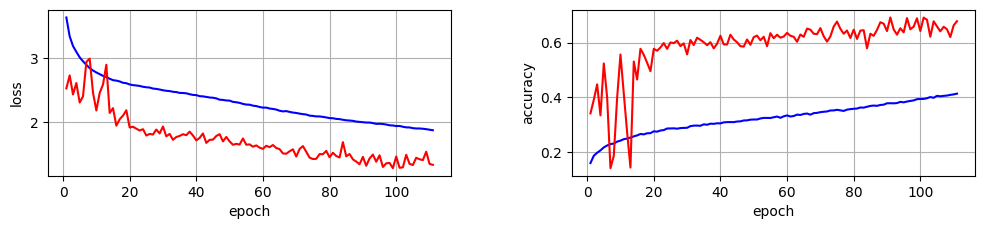

In [9]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 2.25))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

xx = np.arange(1, len(H.history["loss"]) + 1)

# Loss
ax = axs[0]; ax.grid(True); ax.set_ylabel("loss")
ax.plot(xx, H.history["loss"],     "b-",  label="loss")
ax.plot(xx, H.history["val_loss"], "r-",  label="val_loss")

# Accuracy
ax = axs[1]; ax.grid(True); ax.set_ylabel("accuracy")
ax.plot(xx, H.history["accuracy"],     "b-", label="accuracy")
ax.plot(xx, H.history["val_accuracy"], "r-", label="val_accuracy")

for ax in axs: ax.set_xlabel("epoch")
plt.show()


The training curves show a clear separation between training and validation performance.
The loss decreases steadily while the validation loss stabilizes early, indicating that the model learns meaningful patterns but begins to overfit after a few epochs.
Validation accuracy plateaus around 60%, whereas the final test accuracy reaches only 30.5%, suggesting that the network captures style-related cues but struggles to generalize effectively from pixel-level data alone.

We define a custom HyperModel class for Keras Tuner that specifies the architecture and training behavior of the MLP during hyperparameter search.
The build method defines the search space, including the number of hidden layers, layer widths, dropout rates, L2 regularization strength, and learning rate.
Each configuration is compiled with the Adam optimizer and trained using sparse categorical cross-entropy loss.

In [10]:
import keras_tuner as kt

class MLPHyperModel(kt.HyperModel):
    def build(self, hp: kt.HyperParameters):
        l2_reg = tf.keras.regularizers.l2(
            hp.Float("l2", min_value=1e-5, max_value=5e-4, sampling="log")
        )

        n_hidden = hp.Choice("n_hidden", values=[2, 3], default=3)

        # Architecture search space
        widths = []
        widths.append(hp.Choice("h1", values=[1536, 2048, 3072], default=2048))
        widths.append(hp.Choice("h2", values=[768, 1024, 1536],  default=1024))
        if n_hidden == 3:
            widths.append(hp.Choice("h3", values=[384, 512, 768], default=512))

        # Dropouts
        d1 = hp.Float("drop1", 0.30, 0.55, step=0.05, default=0.40)
        d2 = hp.Float("drop2", 0.30, 0.55, step=0.05, default=0.40)
        d3 = hp.Float("drop3", 0.40, 0.60, step=0.05, default=0.50)

        inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
        x = tf.keras.layers.Rescaling(1./255)(inputs)
        x = tf.keras.layers.Flatten()(x)

        # Dense layers + BN + Dropout
        x = tf.keras.layers.Dense(widths[0], activation="relu", kernel_regularizer=l2_reg)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(d1)(x)

        x = tf.keras.layers.Dense(widths[1], activation="relu", kernel_regularizer=l2_reg)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(d2)(x)

        if n_hidden == 3:
            x = tf.keras.layers.Dense(widths[2], activation="relu", kernel_regularizer=l2_reg)(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Dropout(d3)(x)

        outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
        model = tf.keras.Model(inputs, outputs)

        lr = hp.Float("lr", min_value=5e-5, max_value=5e-4, sampling="log", default=1e-4)
        opt = tf.keras.optimizers.Adam(learning_rate=lr)

        model.compile(
            optimizer=opt,
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        # ReduceLROnPlateau
        factor   = hp.Float("rlr_factor", min_value=0.1, max_value=0.6, step=0.1, default=0.5)
        patience = hp.Choice("rlr_patience", values=[2, 3, 4, 5], default=3)

        reduce_cb = tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=factor, patience=patience, min_lr=1e-5, verbose=0
        )

        # EarlyStopping
        es_pat = hp.Choice("es_patience", values=[8, 10, 12, 14], default=12)
        early_cb = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=es_pat, restore_best_weights=True
        )

        callbacks = kwargs.pop("callbacks", [])
        callbacks = callbacks + [reduce_cb, early_cb]

        return model.fit(
            *args,
            epochs=80,
            callbacks=callbacks,
            **kwargs
        )


We initialize a random search tuner from Keras Tuner to explore the hyperparameter space defined in the MLPHyperModel class.  
The tuner evaluates model configurations based on validation accuracy, performing up to six trials with one execution per trial.

In [11]:
tuner = kt.RandomSearch(
    hypermodel=MLPHyperModel(),
    objective="val_accuracy",
    max_trials=6,
    executions_per_trial=1,
    directory="results/kt-mlp",
    project_name="ArtBench10-MLP",
    overwrite=True,
    seed=SEED,
)

tuner.search_space_summary()

search_hist = tuner.search(
    train_ds,
    validation_data=val_ds,
    verbose=0,
)


Search space summary
Default search space size: 9
l2 (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.0005, 'step': None, 'sampling': 'log'}
n_hidden (Choice)
{'default': 3, 'conditions': [], 'values': [2, 3], 'ordered': True}
h1 (Choice)
{'default': 2048, 'conditions': [], 'values': [1536, 2048, 3072], 'ordered': True}
h2 (Choice)
{'default': 1024, 'conditions': [], 'values': [768, 1024, 1536], 'ordered': True}
h3 (Choice)
{'default': 512, 'conditions': [], 'values': [384, 512, 768], 'ordered': True}
drop1 (Float)
{'default': 0.4, 'conditions': [], 'min_value': 0.3, 'max_value': 0.55, 'step': 0.05, 'sampling': 'linear'}
drop2 (Float)
{'default': 0.4, 'conditions': [], 'min_value': 0.3, 'max_value': 0.55, 'step': 0.05, 'sampling': 'linear'}
drop3 (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.4, 'max_value': 0.6, 'step': 0.05, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 5e-05, 'max_value': 0.0005, 'step':

In [12]:
tuner.results_summary(num_trials=5)

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest hyperparameters:")
for k, v in best_hp.values.items():
    print(f"{k}: {v}")

Results summary
Results in results/kt-mlp/ArtBench10-MLP
Showing 5 best trials
Objective(name="val_accuracy", direction="max")

Trial 3 summary
Hyperparameters:
l2: 5.8340797234095194e-05
n_hidden: 2
h1: 3072
h2: 1536
h3: 384
drop1: 0.35
drop2: 0.45
drop3: 0.4
lr: 0.00015672063192316227
rlr_factor: 0.4
rlr_patience: 2
es_patience: 14
Score: 0.7904000282287598

Trial 0 summary
Hyperparameters:
l2: 0.00012200200009846112
n_hidden: 2
h1: 2048
h2: 768
h3: 768
drop1: 0.4
drop2: 0.45
drop3: 0.4
lr: 0.00015721955876355395
rlr_factor: 0.5
rlr_patience: 3
es_patience: 12
Score: 0.7409999966621399

Trial 2 summary
Hyperparameters:
l2: 5.7052961320881516e-05
n_hidden: 2
h1: 2048
h2: 768
h3: 384
drop1: 0.5
drop2: 0.5
drop3: 0.55
lr: 0.00010537154554799555
rlr_factor: 0.1
rlr_patience: 3
es_patience: 14
Score: 0.7293000221252441

Trial 5 summary
Hyperparameters:
l2: 4.856759873449834e-05
n_hidden: 2
h1: 2048
h2: 768
h3: 768
drop1: 0.55
drop2: 0.55
drop3: 0.5
lr: 8.819662451317951e-05
rlr_factor: 0.

In [13]:
# Reconstruct the best model
best_model = tuner.hypermodel.build(best_hp)
best_model.summary()

# Callbacks for final training
rlr_cb_best = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=best_hp.get("rlr_factor"),
    patience=best_hp.get("rlr_patience"),
    min_lr=1e-5,
    verbose=0
)
early_cb_best = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=best_hp.get("es_patience"),
    restore_best_weights=True
)

EPOCHS_FINAL = 200
H_best = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FINAL,
    callbacks=[rlr_cb_best, early_cb_best],
    verbose=0,
)

test_loss_best, test_acc_best = best_model.evaluate(test_ds, verbose=0)
print(f"Accuracy: {test_acc_best:.2%}")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3072)           │    37,751,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3072)           │        12,288 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1536)           │     4,720,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        15,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,505,738 (162.15 MB)

 Trainable params: 42,496,522 (162.11 MB)

 Non-trainable params: 9,216 (36.00 KB)

Accuracy: 28.79%


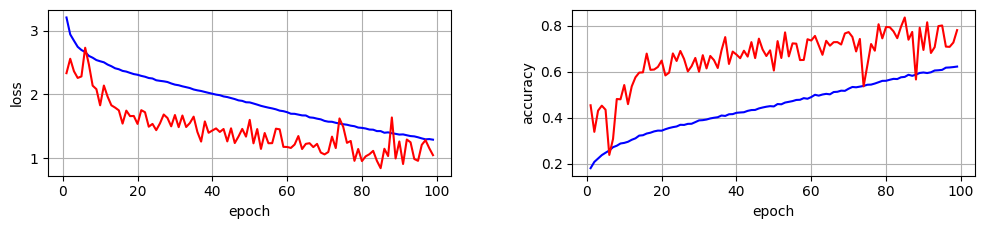

In [14]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 2.25))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

xx = np.arange(1, len(H_best.history["loss"]) + 1)

# Loss
ax = axs[0]; ax.grid(True); ax.set_ylabel("loss")
ax.plot(xx, H_best.history["loss"],     "b-",  label="loss")
ax.plot(xx, H_best.history["val_loss"], "r-",  label="val_loss")

# Accuracy
ax = axs[1]; ax.grid(True); ax.set_ylabel("accuracy")
ax.plot(xx, H_best.history["accuracy"],     "b-", label="accuracy")
ax.plot(xx, H_best.history["val_accuracy"], "r-", label="val_accuracy")

for ax in axs: ax.set_xlabel("epoch")
plt.show()

In [15]:
from sklearn.metrics import classification_report

y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred = np.argmax(best_model.predict(test_ds, verbose=0), axis=1)
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

                    precision    recall  f1-score   support

       art_nouveau      0.276     0.320     0.296      1000
           baroque      0.329     0.402     0.362      1000
     expressionism      0.151     0.085     0.109      1000
     impressionism      0.234     0.160     0.190      1000
post_impressionism      0.230     0.183     0.204      1000
           realism      0.210     0.167     0.186      1000
       renaissance      0.321     0.221     0.262      1000
       romanticism      0.250     0.210     0.228      1000
        surrealism      0.242     0.342     0.283      1000
           ukiyo_e      0.430     0.789     0.556      1000

          accuracy                          0.288     10000
         macro avg      0.267     0.288     0.268     10000
      weighted avg      0.267     0.288     0.268     10000



The model performs worse because the small hyperparameter search likely overfitted to the validation set.
During tuning, the algorithm selected parameters that happened to work best on that specific validation split, rather than ones that generalize well.
As a result, while validation accuracy looked good during the search, the chosen configuration did not transfer effectively to unseen test data.